# Action Graph 

### Goals:

- A graph store/database to store and trace any computations during eager execution
- Graph that works with the current in memory worker
- Ability to visualize the graph
- Generate a dependecy list of node, so that any dependeny action can be generated
- Basic query/search functionalities
- Locking/Concurrency

In [3]:
import syft as sy
from syft.service.action.action_graph_service import ActionGraphService, NodeActionDataUpdate, ExecutionStatus
from syft.service.action.action_graph import InMemoryActionGraphStore, InMemoryGraphConfig, InMemoryStoreClientConfig

from syft.service.context import AuthedServiceContext
from syft.node.credentials import SyftSigningKey
from syft.service.action.action_graph import Action
from syft.service.action.numpy import NumpyArrayObject, ActionObject
import numpy as np
import matplotlib.pyplot as plt

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/shubham/PySyft


## Scenario for performing some computation

```python

import syft as sy

domain_client = sy.login("....")

dataset = domain_client.datasets[0]

a = dataset.assets["A"]

b = dataset.assets["B"]

c = a + b

d = domain_client.api.numpy.array([1, 2, 3])

e = c * d

# Inplace operation, mutated the value of d
d.astype('int32')

f = d + 48
```

<br>
<br>

**Corresponding Actions Generated**

```

action1 -> a + b

action2 -> initialization of variable `d`

action3 -> c * d

action4 -> inplace updation of type of `d` (d.astype('int32'))

action5 -> d + 48

```

![graph.png](graph.png)

### Initializing the Store

In [4]:
# Create a Config

store_config = InMemoryGraphConfig()

In [5]:
# Initialize the InMemory Store

graph_store = InMemoryActionGraphStore(store_config=store_config)

### Initializing Action Graph Service

In [6]:
action_graph_service = ActionGraphService(store=graph_store)

In [7]:
signing_key = SyftSigningKey.generate()
authed_context = AuthedServiceContext(credentials=signing_key.verify_key)

In [8]:
signing_key = SyftSigningKey.generate()
authed_context = AuthedServiceContext(credentials=signing_key.verify_key)

### Create some dummy data

In [9]:
labels_dict = {}

In [10]:
action_obj_a = ActionObject.from_obj([2, 4, 6])
action_obj_b = ActionObject.from_obj([2, 3, 4])

In [11]:
labels_dict[action_obj_a.id] = "A"
labels_dict[action_obj_b.id] = "B"

In [12]:
action_obj_a.id, action_obj_b.id

(<UID: d3d285e8dca04a57a2e07f467ae1ae57>,
 <UID: 88d2c730b37845f6a12ce332e52ee14c>)

In [13]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_a)

```python
class NodeActionData:
  id: str = d3d285e8dca04a57a2e07f467ae1ae57
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 01:42:00
  updated_at: str = None
  user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
  is_mutated: str = False

```

In [14]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_b)

```python
class NodeActionData:
  id: str = 88d2c730b37845f6a12ce332e52ee14c
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 01:42:00
  updated_at: str = None
  user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
  is_mutated: str = False

```

### Action1 -> A + B

In [15]:
action1 = Action(
    path="action.execute",
    op="__add__",
    remote_self=action_obj_a.syft_lineage_id,
    args=[action_obj_b.syft_lineage_id],
    kwargs={}
)
action1

```python
class Action:
  id: str = 356383a938144d808674782cdde39ce9
  path: str = "action.execute"
  op: str = "__add__"
  remote_self: str = d3d285e8dca04a57a2e07f467ae1ae57
  args: str = [<LineageID: 88d2c730b37845f6a12ce332e52ee14c - 559322357486915875>]
  kwargs: str = {}
  result_id: str = 51794a4c884e4a069bd3ff0445af62dc

```

In [16]:
labels_dict[action1.id] = "+"
labels_dict[action1.result_id.id] = "C"

### Save action to Graph

In [17]:
# action_graph_service.add_action

In [18]:
action_graph_service.add_action(context=authed_context, action=action1)

(class NodeActionData:
   id: str = 356383a938144d808674782cdde39ce9
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:02
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = False,
 class NodeActionData:
   id: str = 51794a4c884e4a069bd3ff0445af62dc
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:02
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = False)

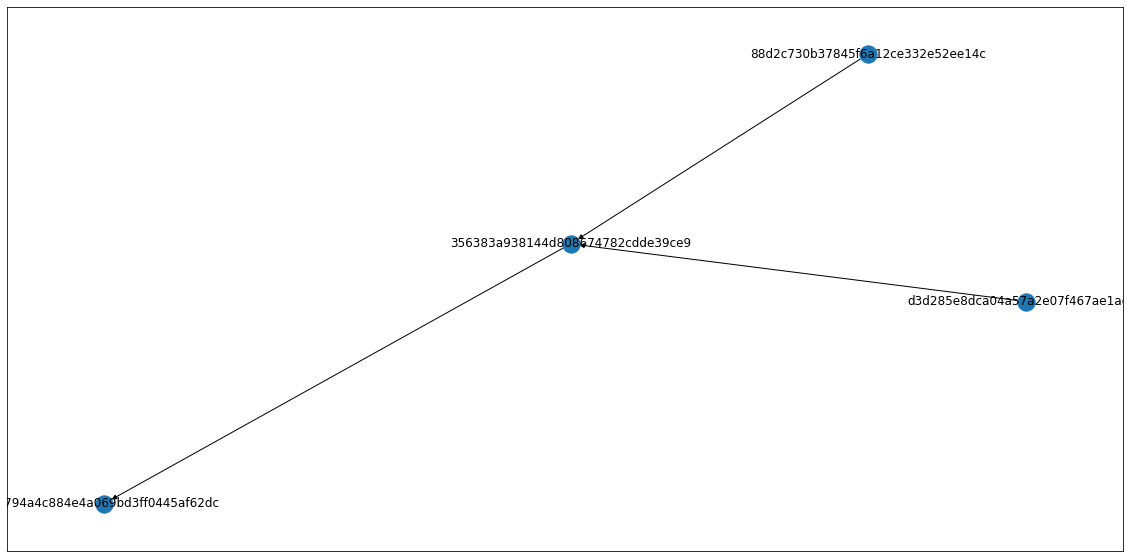

In [19]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

### Action2 -> np.array([1, 2, 3])

In [20]:
action_obj_d = ActionObject.from_obj([1, 2, 3])

In [21]:
labels_dict[action_obj_d.id] = "[1, 2 ,3]"

In [22]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_d)

```python
class NodeActionData:
  id: str = df035b2073844942950f17a8a7c47cd1
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 01:42:04
  updated_at: str = None
  user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
  is_mutated: str = False

```

In [23]:
# Create Action2

action2 = Action(
    path="action.execute",
    op="np.array",
    remote_self=None,
    args=[action_obj_d.syft_lineage_id],
    kwargs={}
)
action2

```python
class Action:
  id: str = a0be00413bea4510b669831f919601b7
  path: str = "action.execute"
  op: str = "np.array"
  remote_self: str = None
  args: str = [<LineageID: df035b2073844942950f17a8a7c47cd1 - 948553819202438941>]
  kwargs: str = {}
  result_id: str = 54ea2f8fee5a45fd8a4b8e5e560de556

```

In [24]:
labels_dict[action2.id] = "np.array"
labels_dict[action2.result_id.id] = "D"

In [25]:
# Save action to graph
action_graph_service.add_action(context=authed_context, action=action2)

(class NodeActionData:
   id: str = a0be00413bea4510b669831f919601b7
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:06
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = False,
 class NodeActionData:
   id: str = 54ea2f8fee5a45fd8a4b8e5e560de556
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:06
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = False)

In [26]:
# 747749f9494345b78e165f13351e52bf: {"data": NodeActionData()}

In [27]:
action1.result_id.id

<UID: 51794a4c884e4a069bd3ff0445af62dc>

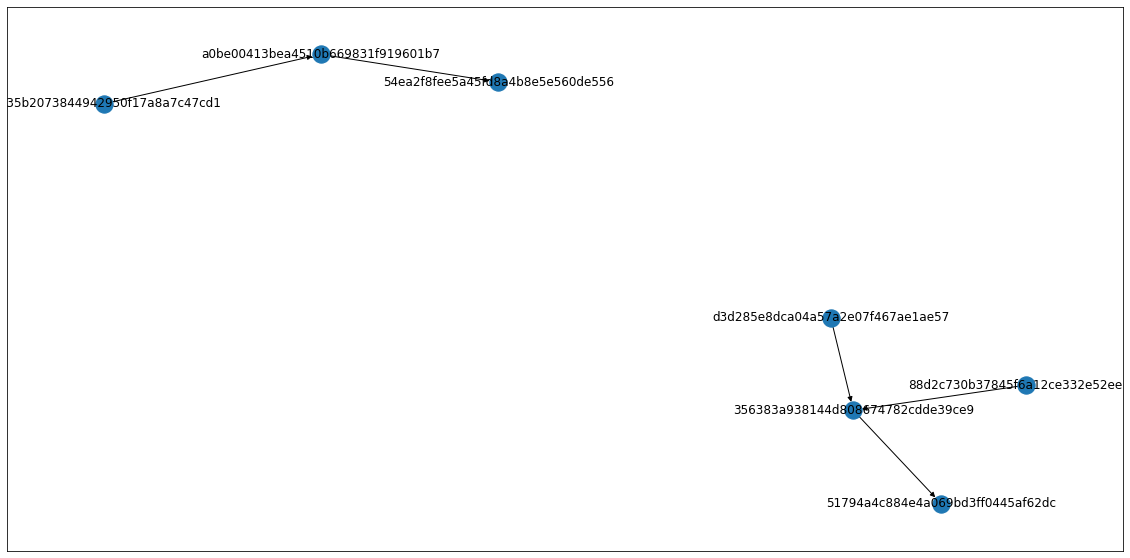

In [28]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

### Action3 -> C * D

In [29]:
action3 = Action(
    path="action.execute",
    op="__mul__",
    remote_self=action1.result_id,
    args=[action2.result_id],
    kwargs={}
)
action3

```python
class Action:
  id: str = c96ec6d8e7b84344a30ed58b33cb9f01
  path: str = "action.execute"
  op: str = "__mul__"
  remote_self: str = 51794a4c884e4a069bd3ff0445af62dc
  args: str = [<LineageID: 54ea2f8fee5a45fd8a4b8e5e560de556 - 1269182617662526807>]
  kwargs: str = {}
  result_id: str = 3a43834239de4feda93e03a680ac1cd3

```

In [30]:
action_graph_service.add_action(context=authed_context, action=action3)

(class NodeActionData:
   id: str = c96ec6d8e7b84344a30ed58b33cb9f01
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:09
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = False,
 class NodeActionData:
   id: str = 3a43834239de4feda93e03a680ac1cd3
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:09
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = False)

In [31]:
labels_dict[action3.id] = "*"
labels_dict[action3.result_id.id] = "E"

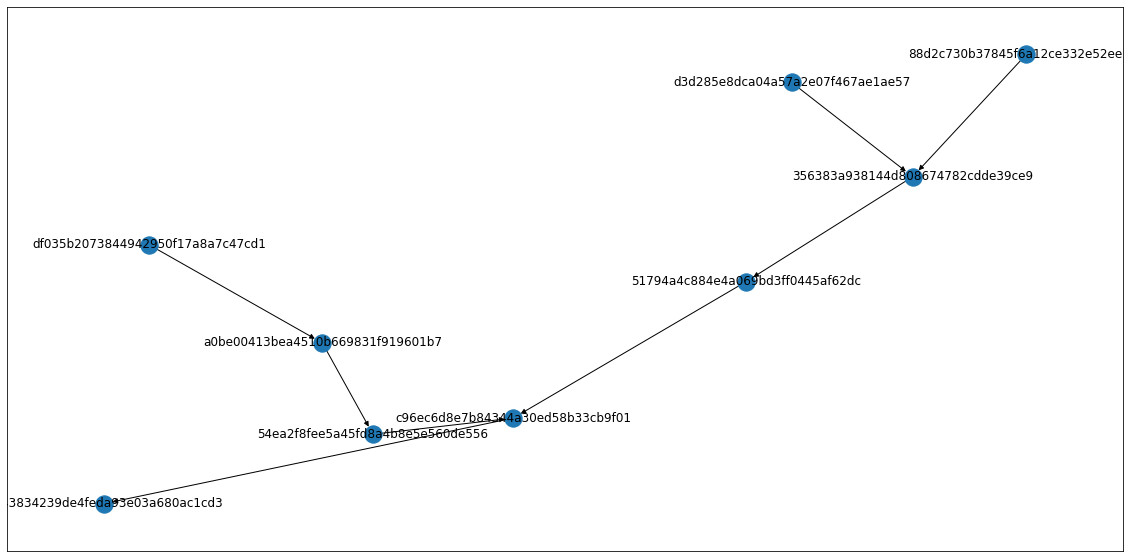

In [32]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

### Action4 -> Mutate type of D

In [33]:
as_type_action_obj = ActionObject.from_obj('np.int32')

In [34]:
action_graph_service.add_action_obj(context=authed_context, action_obj=as_type_action_obj)

```python
class NodeActionData:
  id: str = 76be60898f7f4f888e589a755284791c
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 01:42:10
  updated_at: str = None
  user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
  is_mutated: str = False

```

In [35]:
labels_dict[as_type_action_obj.id] = "np.int32"

In [36]:
action4 = Action(
    path="action.execute",
    op="astype",
    remote_self=action2.result_id,
    args=[as_type_action_obj.syft_lineage_id],
    kwargs={},
    result_id=action2.result_id
)
action4

```python
class Action:
  id: str = 3f32db69e24a45ceb3ecf0a6c12d21d7
  path: str = "action.execute"
  op: str = "astype"
  remote_self: str = 54ea2f8fee5a45fd8a4b8e5e560de556
  args: str = [<LineageID: 76be60898f7f4f888e589a755284791c - 309515554635314558>]
  kwargs: str = {}
  result_id: str = 54ea2f8fee5a45fd8a4b8e5e560de556

```

In [37]:
action_graph_service.add_action(context=authed_context, action=action4)

(class NodeActionData:
   id: str = 3f32db69e24a45ceb3ecf0a6c12d21d7
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:11
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = True,
 class NodeActionData:
   id: str = None
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:06
   updated_at: str = 2023-05-03 01:42:11
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = True)

In [38]:
labels_dict[action4.id] = "astype"
labels_dict[action4.result_id.id] = "D1"

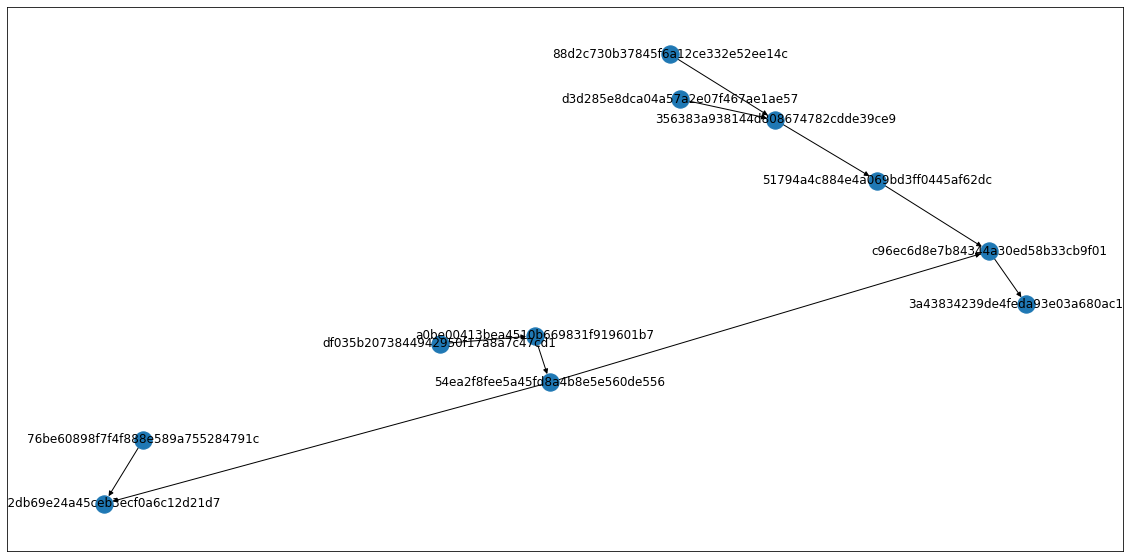

In [39]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

In [40]:
action_graph_service.store.get(uid=action2.id, credentials=authed_context.credentials).ok()

```python
class NodeActionData:
  id: str = a0be00413bea4510b669831f919601b7
  type: str = NodeType.ACTION
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 01:42:06
  updated_at: str = None
  user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
  is_mutated: str = False

```

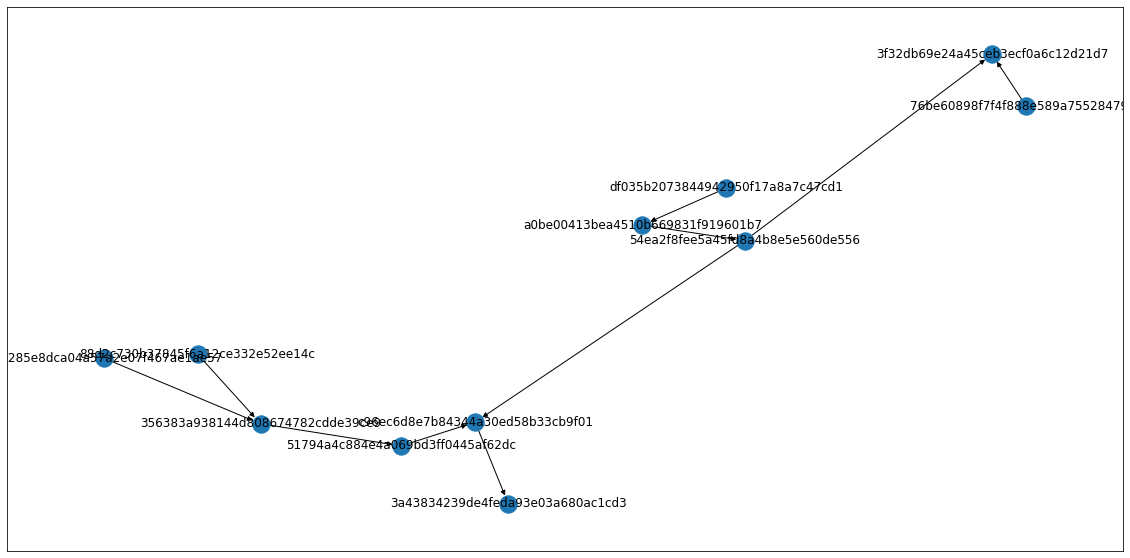

In [41]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

### Action5 -> D + 48

In [42]:
arg_action_obj = ActionObject.from_obj(48)

In [43]:
action_graph_service.add_action_obj(context=authed_context, action_obj=arg_action_obj)

```python
class NodeActionData:
  id: str = d24fa309528f4daa9448b196eb850069
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 01:42:13
  updated_at: str = None
  user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
  is_mutated: str = False

```

In [44]:
labels_dict[arg_action_obj.id] = "48"

In [45]:
# action2.result_id == action4.result_id

In [46]:
action5 = Action(
    path="action.execute",
    op="__add__",
    remote_self=action2.result_id,
    args=[arg_action_obj.syft_lineage_id],
    kwargs={},
)
action5

```python
class Action:
  id: str = c840c1478aae4b86801f35c4a2f021c7
  path: str = "action.execute"
  op: str = "__add__"
  remote_self: str = 54ea2f8fee5a45fd8a4b8e5e560de556
  args: str = [<LineageID: d24fa309528f4daa9448b196eb850069 - 488018104991837682>]
  kwargs: str = {}
  result_id: str = 7ca13aa4ac5848c5a055efedbd2c3550

```

In [47]:
action_graph_service.add_action(context=authed_context, action=action5)

(class NodeActionData:
   id: str = c840c1478aae4b86801f35c4a2f021c7
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:14
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = False,
 class NodeActionData:
   id: str = 7ca13aa4ac5848c5a055efedbd2c3550
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 01:42:14
   updated_at: str = None
   user_verify_key: str = 8898f4fc6f087383093b2bae8adfe04487a09aa1ddd1f93dff721453b48262ea
   is_mutated: str = False)

In [48]:
labels_dict[action5.id] = "+"
labels_dict[action5.result_id.id] = "F"

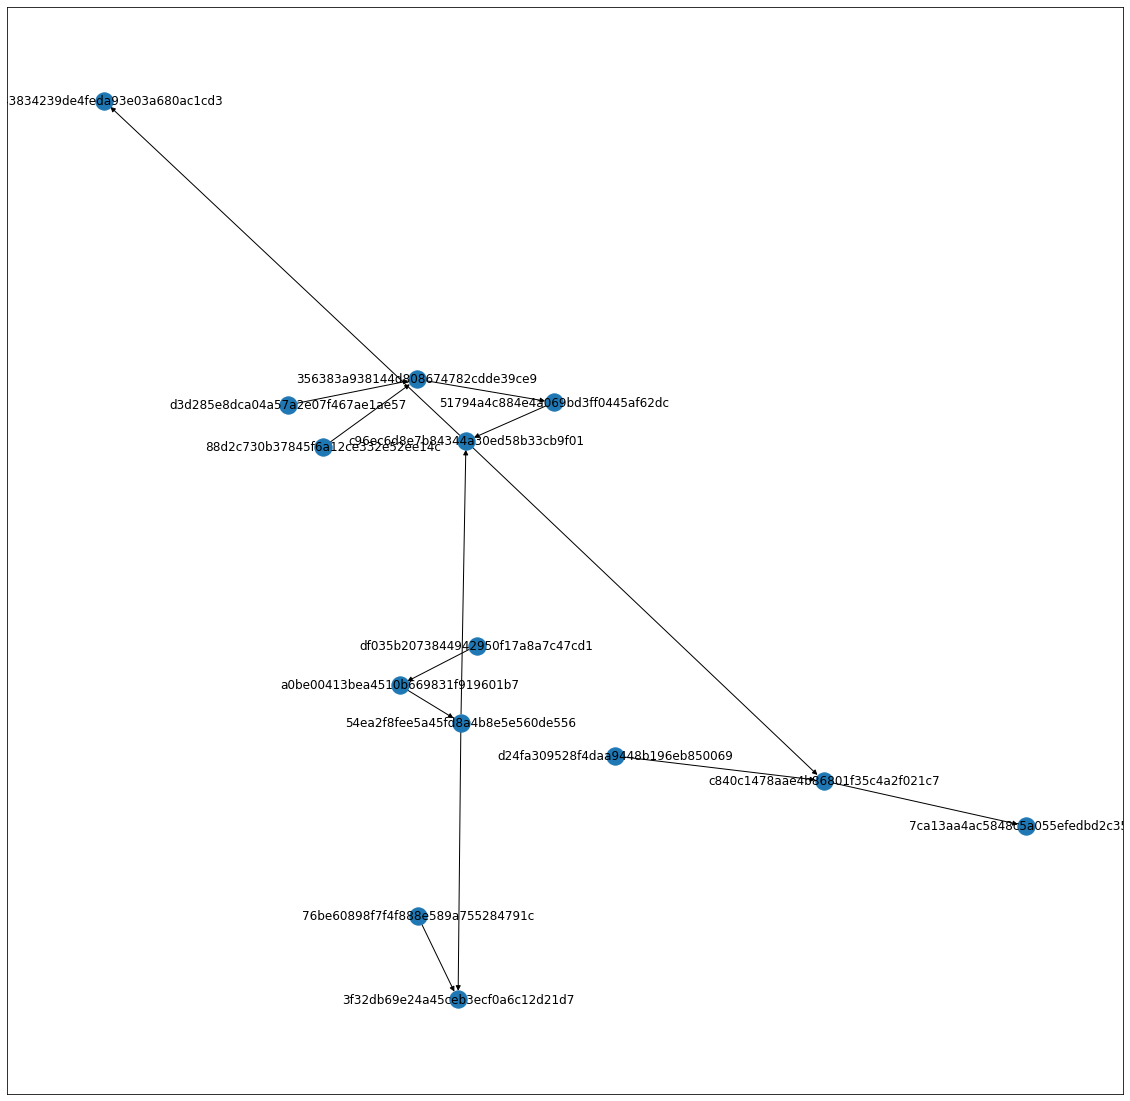

In [49]:
plt.figure(figsize=(20, 20))
action_graph_service.store.graph.visualize()

In [50]:
action_obj_a.id, action_obj_b.id, action_obj_d.id, as_type_action_obj.id, arg_action_obj.id

(<UID: d3d285e8dca04a57a2e07f467ae1ae57>,
 <UID: 88d2c730b37845f6a12ce332e52ee14c>,
 <UID: df035b2073844942950f17a8a7c47cd1>,
 <UID: 76be60898f7f4f888e589a755284791c>,
 <UID: d24fa309528f4daa9448b196eb850069>)

In [51]:
action1.id, action2.id, action3.id, action4.id, action5.id

(<UID: 356383a938144d808674782cdde39ce9>,
 <UID: a0be00413bea4510b669831f919601b7>,
 <UID: c96ec6d8e7b84344a30ed58b33cb9f01>,
 <UID: 3f32db69e24a45ceb3ecf0a6c12d21d7>,
 <UID: c840c1478aae4b86801f35c4a2f021c7>)

In [52]:
len(labels_dict)

14

In [53]:
G = action_graph_service.store.graph.db

In [54]:
import networkx as nx

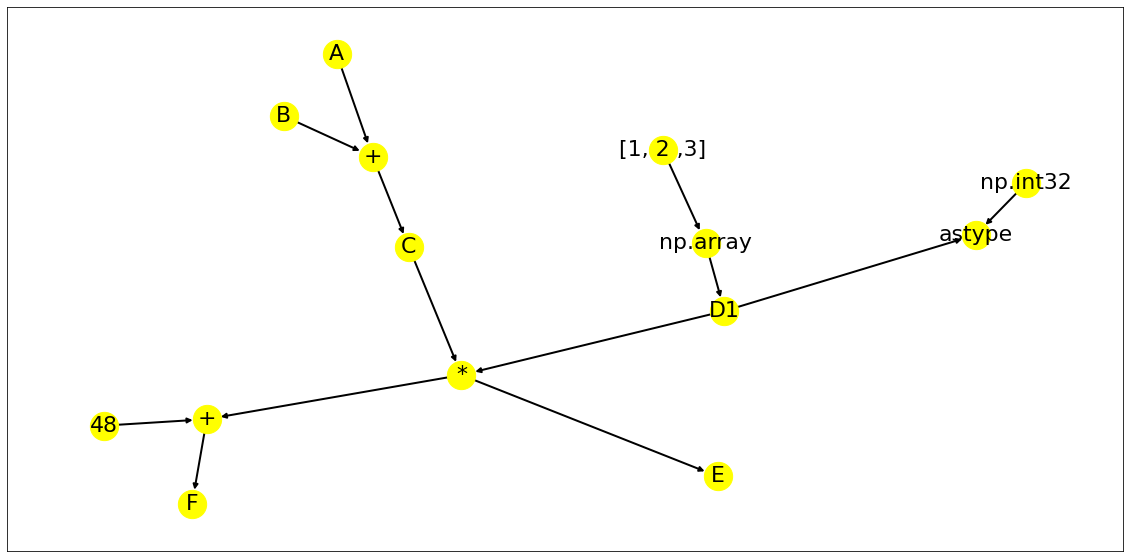

In [68]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

In [62]:
labels_dict.values()

dict_values(['A', 'B', '+', 'C', '[1, 2 ,3]', 'np.array', 'D1', '*', 'E', 'np.int32', 'astype', '48', '+', 'F'])

```

action1 -> a + b

action2 -> initialization of variable `d`

action3 -> c * d

action4 -> inplace updation of type of `d` (d.astype('int32'))

action5 -> d + 48

```

## Filtering Actions in the Graph

### Filter by ActionStatus

```
ActionStatus
- PROCESSING
- DONE
- FAILED
```

In [ ]:
action_graph_service.get_by_action_status(context=authed_context, status=ActionStatus.PROCESSING)

In [ ]:
action_graph_service.get_by_action_status(context=authed_context, status=ActionStatus.DONE)

### Filter by Particular User

In [ ]:
action_graph_service.get_by_verify_key(context=authed_context, verify_key=signing_key.verify_key)

In [ ]:
### Serde 

In [ ]:
# bytes_data = sy.serialize(graph_store, to_bytes=True)

In [ ]:
# graph_store = sy.deserialize(bytes_data, from_bytes=True)